In [14]:
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

plt.style.use("ggplot")

In [15]:
variable_name = "tas"

This notebook compares the estimation with a rolling-window-based approach compared to the original approach modelling seasonality with modes.

Data with e.g. `window-size=31` needs to be generated for the respective variable with the following command (here `--variable tas`):

```bash
attrici detrend --gmt-file ./tests/data/20CRv3-ERA5_germany_ssa_gmt.nc \
                --input-file ./tests/data/20CRv3-ERA5_germany_obs.nc \
                --output-dir ./tests/data/output-windowed --variable tas \
                --stop-date "2023-12-31" --report-variables y cfact logp  \
                --window-size 31 --cache-dir cache --overwrite
```

In [16]:
data_modes = xr.load_dataset(
    f"../tests/data/output/pymc5/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.nc"
)
data_windowed = xr.load_dataset(
    f"../tests/data/output-windowed/timeseries/{variable_name}/lat_50.75/ts_lat50.75_lon9.25.nc"
)

In [17]:
window_size = [
    line
    for line in data_windowed.attrs["attrici_config"].split("\n")
    if "window_size" in line
][0]
modes = [
    line for line in data_modes.attrs["attrici_config"].split("\n") if "modes" in line
][0]

Comparison of `y` and `cfact` for a single year

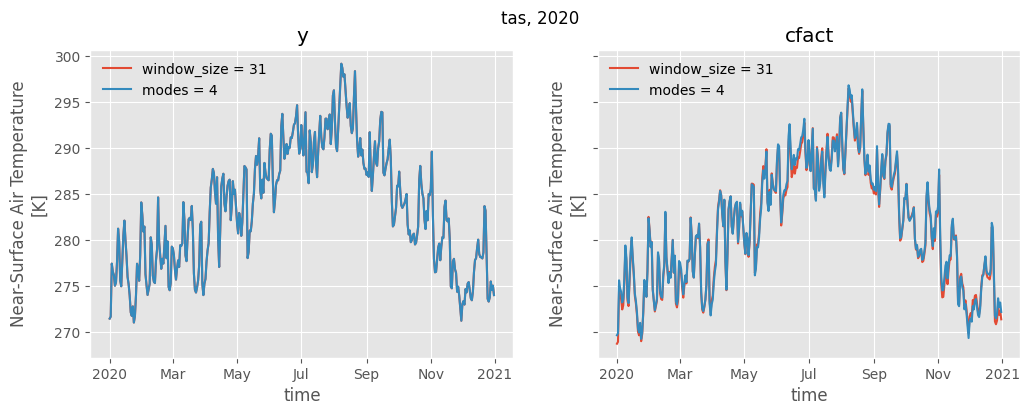

In [18]:
year = "2020"

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle(f"{variable_name}, {year}")

data_windowed.y.loc[year].plot(ax=ax[0], label=window_size)
data_modes.y.loc[year].plot(ax=ax[0], label=modes)
ax[0].legend(frameon=False)

data_windowed.cfact.loc[year].plot(ax=ax[1], label=window_size)
data_modes.cfact.loc[year].plot(ax=ax[1], label=modes)
ax[1].legend(frameon=False)

ax[0].set_title("y")
ax[1].set_title("cfact");

For a single month:

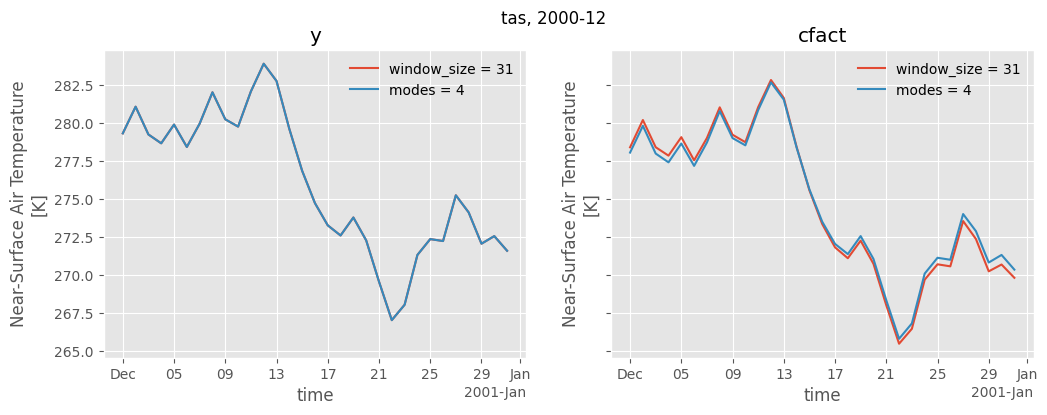

In [19]:
year = "2000-12"

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle(f"{variable_name}, {year}")

data_windowed.y.loc[year].plot(ax=ax[0], label=window_size)
data_modes.y.loc[year].plot(ax=ax[0], label=modes)
ax[0].legend(frameon=False)

data_windowed.cfact.loc[year].plot(ax=ax[1], label=window_size)
data_modes.cfact.loc[year].plot(ax=ax[1], label=modes)
ax[1].legend(frameon=False)

ax[0].set_title("y")
ax[1].set_title("cfact");

Comparison of values in a histogram

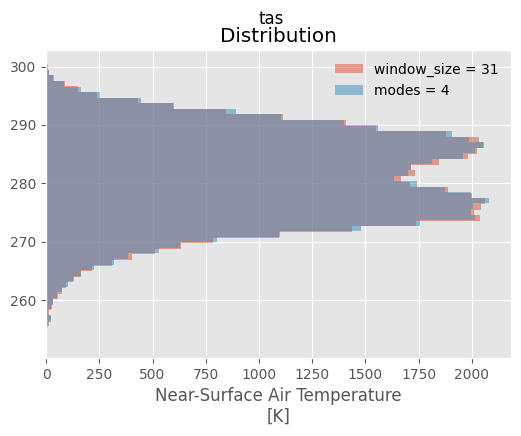

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fig.suptitle(variable_name)

data_windowed.cfact.plot.hist(
    ax=ax, bins=50, label=window_size, orientation="horizontal", alpha=0.5
)
data_modes.cfact.plot.hist(
    ax=ax, bins=50, label=modes, orientation="horizontal", alpha=0.5
)
ax.set_title("Distribution")
ax.legend(frameon=False);

Comparison between the modes based and window based approach

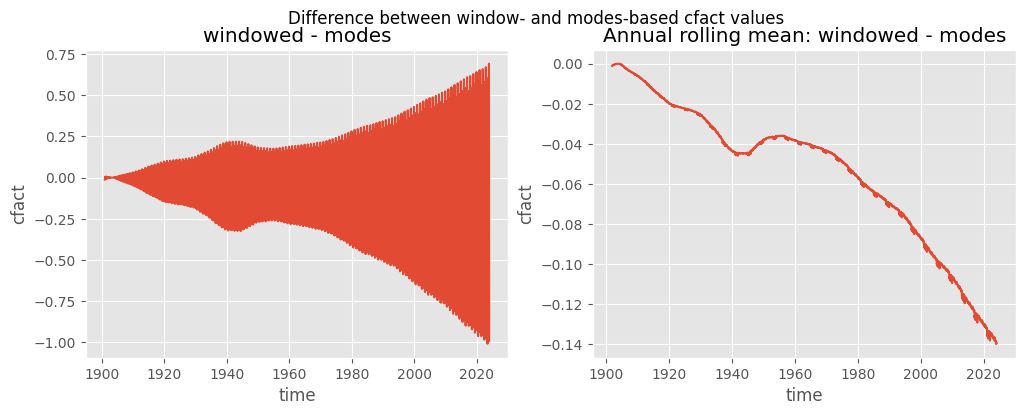

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
(data_windowed.cfact - data_modes.cfact).plot(ax=ax[0])
ax[0].set_title("windowed - modes")

(data_windowed.cfact - data_modes.cfact).rolling(time=365).mean().plot(ax=ax[1])
ax[1].set_title("Annual rolling mean: windowed - modes")

fig.suptitle("Difference between window- and modes-based cfact values");

The windowed approach has one particularity - it fits according to windows around each day of year. As for leap years, March 1st is the 61st day of the year, but for non-leap years it is the 60th, one has to consider this one day shift when directly comparing different years. In the plots below this effect is shown comparing the differences from one day to the next for conterfactual, `cfact`, as well as for the observations time series, `y`. The latter does not have such a shift, hence leap years show as outliers below. This effect is very small (note the absolute value changes from one day to the next in the left panels), but systematic. See also the small spikes in the rolling mean figure above.


In [22]:
1904, pd.Timestamp("1904-03-01").dayofyear, 1905, pd.Timestamp("1905-03-01").dayofyear

(1904, 61, 1905, 60)

In [23]:
def plot_differences(
    month_day, start_year=2000, stop_year=2020, consider_leapyear=False
):
    diffs = []
    for x in range(start_year, stop_year, 1):
        day = pd.Timestamp(f"{x}-{month_day}")
        # Compare actual day of year not date
        if consider_leapyear and calendar.isleap(x):
            day = day - pd.Timedelta(days=1)
        next_day = day + pd.Timedelta(days=1)

        diffs.append(
            [
                data_windowed.cfact.loc[next_day].item()
                - data_windowed.cfact.loc[day].item(),
                data_windowed.y.loc[next_day].item() - data_windowed.y.loc[day].item(),
            ]
        )
    diffs = np.array(diffs)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(range(start_year, stop_year), diffs[:, 0])
    ax[0].plot(range(start_year, stop_year), diffs[:, 1])
    ax[1].plot(range(start_year, stop_year), diffs[:, 0] - diffs[:, 1])

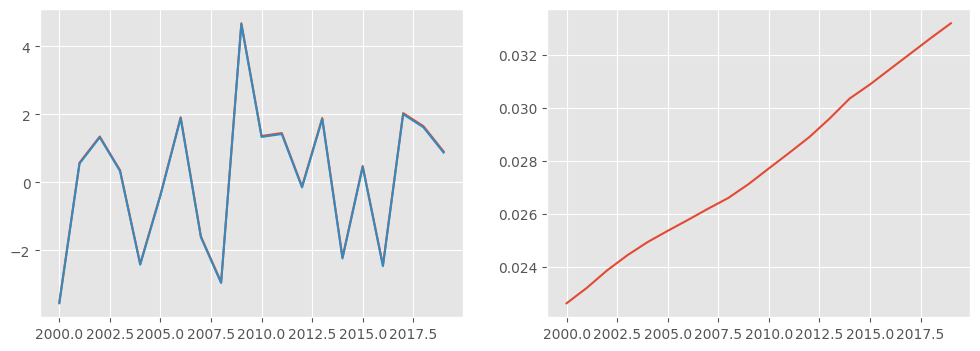

In [24]:
plot_differences("02-15", consider_leapyear=False)

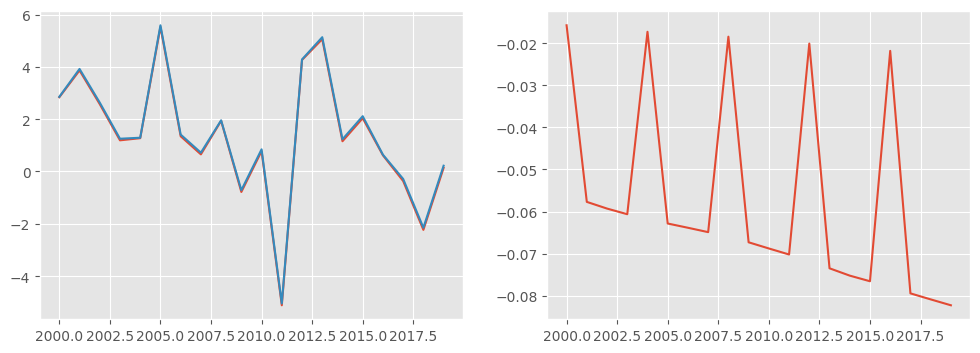

In [25]:
plot_differences("03-15", consider_leapyear=False)

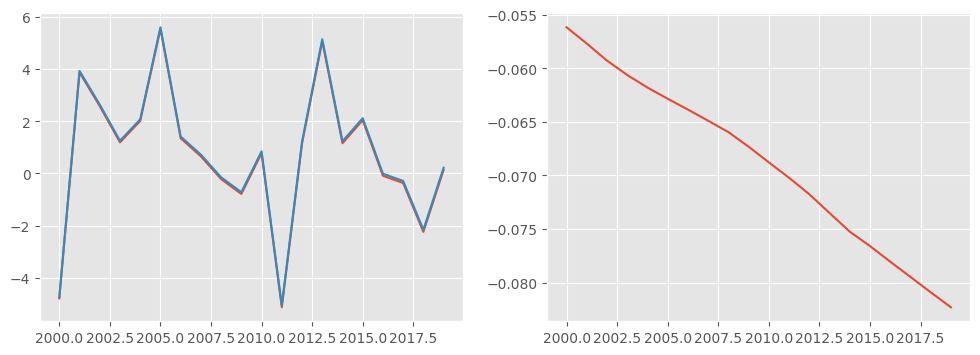

In [26]:
plot_differences("03-15", consider_leapyear=True)